# Домашнее задание по transfer learning

* Тема: выполнить transfer learning + fine-tuning для модели на собранном датасете. Примеры датасетов: киты и акулы, снятых под водой; экзотические птицы; фрукты и овощи; и так далее.
* Работа ведется на tensorflow. За основу можно взять готовые материалы или ноутбуки: [tf](https://colab.research.google.com/drive/18N3JWFS7v2MB_9owoLpXZE_NS8orGo2h?usp=sharing), [keras.io](https://keras.io/guides/transfer_learning/), (если ссылки не работают, напишите @Mikhail Stepanov в slack).
* Результатом работы должен быть обученный классификатор:
  * Сама модель и графики ее обучения
  * Пример работы на нескольких изображениях
  * Ноутбук с кодом обучения

# Более подробные инструкции
* Выполнять д/з можно в ноутбуках, скриптах .py, colab - где удобнее.
* Для сборки датасета используйте [fatkun](https://chrome.google.com/webstore/detail/fatkun-batch-download-ima/nnjjahlikiabnchcpehcpkdeckfgnohf?hl=en). Работает, к сожалению, только в Google Chrome. Можно использовать и другие инструменты (js/python скрипты), но времени потратите больше, скорее всего.
* Для начала сборки датасета попробуйте два запроса: whale underwater, shark underwater. Начните с нескольких сотен изображений (подготовка займет ~40 минут), обучите сеть на них. (*Если у вас мало времени/другие сложности со сбором данных, можете взять готовый датасет, инструкция в конце ноутбука. Но советую попробовать собрать свой*)
* Не нужно чрезмерных усилий, хватит ~100-200 картинок на каждый класс для старта. Не забывайте про базовую аугментацию.
* Не забудьте сделать train, validation, test - сплиты! Тестовый сплит понадобится для честной model selection (напоминаю, что early stopping - это тоже техника model selection).
* Задание:
  * Подготовьте данные. Поскольку дальше будут использоваться параметры ImageNet, рекомендую приводить картинки к формату (224, 224) и использовать такой же размер входного слоя сети.
  * Постройте t-SNE представление векторов, полученных feature extractor'ом. (можно поэкспериментировать с t-SNE, в частности, попробовать 3D-графики).
  * Поэкспериментируйте с разным количеством добавленных слоев классификатора и количеством нейронов в них. *Будет ли модель обучаться, и если да, то в каких условиях*, если добавить один полносвязный слой классификатора непосредственно к feature extractor'у? 
  * Обучите модель transfer learning, взяв за основу любую модель, обученную на ImageNet. Если у вас два класса, постарайтесь получить accuracy 0.75+ для сбалансированной тестовой выборки :) Можно больше.
  * После того, как модель будет обучена, выполните fine-tuning, разморозив основную часть весов модели. Постройте предствление t-SNE векторных представлений после fine-tuning'a и сравните с тем, которое было до него. Fine-tuning можно выполнять как с метками, так и при помощи triplet loss'a.
  * Также добавьте loss/accuracy графики для обучающих и валидационных данных.Можно сделать это в tensorboard.
  * *Дополнительно*: подумайте, как сочетание подхода с поиском векторных представлений и аугментаию можно использовать для обучения на данных с частичной или отсутсвующей разметкой. Интересно обсудить ваши идеи.
* Пришлите ссылку на ноутбук с кодом / скрипты как результаты работы.
* Если есть вопросы - пишите в slack.




# Код, который может понадобиться

In [80]:
# %tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_addons as tfa


from numpy.linalg import norm
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from PIL import Image
import io
import datetime
import random
import shutil
import os
import pathlib


def make_tsne_plot(vectors, labels):
  pca_dimension = 100
  if vectors.shape[1] <= pca_dimension * 2:
    pca_vectors = vectors
  else:
    pca = PCA(pca_dimension)
    pca.fit(vectors)
    pca_vectors = pca.transform(vectors)

  tsne_results = TSNE(n_components=2,
                      verbose=1,
                      metric='euclidean').fit_transform(pca_vectors) 

  cmap = plt.cm.get_cmap('coolwarm')
  plt.figure(figsize=(10, 8), dpi=80)
  scatter = plt.scatter(tsne_results[:,0],
                        tsne_results[:,1], 
                        c=labels, 
                        cmap=cmap)
  plt.colorbar(scatter)
  plt.show()


def make_extractor(img_shape, model=None, 
                   dropout_rate=0.25, trainable=False):
  if model is None:
    extractor = keras.applications.InceptionResNetV2(
        include_top=False, weights="imagenet")
  else:
    extractor = model(include_top=False, weights="imagenet")
  for layer in extractor.layers:
    layer.trainable = trainable

  gap = keras.layers.GlobalAveragePooling2D()
  dropout = keras.layers.Dropout(dropout_rate)

  input = keras.layers.Input(img_shape)
  x = extractor(input)
  x = dropout(x)
  x = gap(x)

  return keras.Model(input, x)

def make_classifier(n_classes, img_shape, model=None, 
                    units=64, dropout_rate=0.25, trainable=False):
  extractor = make_extractor(img_shape, model, 
                             dropout_rate=dropout_rate, trainable=trainable)
  dropout = keras.layers.Dropout(dropout_rate)
  dense_1 = keras.layers.Dense(units, activation='relu')
  dense_2 = keras.layers.Dense(units, activation='relu')
  classifier = keras.layers.Dense(n_classes, activation='softmax')

  input = keras.layers.Input(img_shape)
  x = extractor(input)
  x = classifier(dropout(dense_2(dropout(dense_1(dropout(x))))))

  return keras.Model(input, x)


def make_triple_loss_model(img_shape, model=None, embedding_shape=32, 
                          units=64, dropout_rate=0.25, trainable=False): 
  """
  Создаем модель. По умолчанию - InceptionResNetV2.
  Если передан конструктор model, используется он (должен поддерживать 
  интерфейс keras.applications).
  
  """
  extractor = make_extractor(img_shape, model, 
                             dropout_rate=dropout_rate, 
                             trainable=trainable)

  dense_1 = keras.layers.Dense(units, activation='relu')
  dense_2 = keras.layers.Dense(units, activation='relu')
  embedding_layer = keras.layers.Dense(embedding_shape, activation='linear')
  dropout = keras.layers.Dropout(0.25)

  images = keras.layers.Input(img_shape, name='input_shape')
  labels = keras.layers.Input((1,), name='input_label')

  x = extractor(images)
  x = dropout(x)
  x = dense_1(x)
  x = dropout(x)
  x = dense_2(x)
  embeddings = embedding_layer(x)

  return keras.Model(inputs=images, outputs=embeddings)

def sample_images(generator, n):
    images, labels = next(iter(generator))
    classes = {v:k for k, v in generator.class_indices.items()}
    columns = 4  
    rows = int(16/columns)
    fig, axis = plt.subplots(nrows=rows, ncols=columns, figsize=(8,8))
    for i, ax in enumerate(axis.flat):

        ax.set(title=classes[int(labels[i])])
        ax.imshow((images[i] * 255.).astype(int))
    plt.tight_layout()  
    plt.show()

def show_prediction(images, true_labels, model):
    predict_labels =[int(x) for x in np.argmax(model.predict(images), axis=1)]
    classes = {v:k for k, v in val_generator.class_indices.items()}
    columns = 4  
    rows = int(16/columns)
    fig, axis = plt.subplots(nrows=rows, ncols=columns, figsize=(8,8))
    for i, ax in enumerate(axis.flat):
        if true_labels[i] == predict_labels[i]:
            ax.set_title(classes[int(labels[i])], color='g')
        else:
            ax.set_title(classes[int(predict_labels[i])], color='r')
        ax.imshow((images[i] * 255.).astype(int))
    plt.tight_layout()  
    plt.show()

def normalize_vectors(feature_vectors):
  return feature_vectors / np.expand_dims(norm(feature_vectors, axis=1), 
                                          axis=-1)

def history_show(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ax[0].plot(history.history['loss'], label='train')
    ax[0].plot(history.history['val_loss'],label='val')
    ax[0].set(title='Losses')
    ax[0].legend()
    ax[1].plot(history.history['accuracy'],label='train')
    ax[1].plot(history.history['val_accuracy'],label='val')
    ax[1].set(title='Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()
    
def make_backbone_trainable(classifier):
  trainable_backbone = make_classifier(3, IMG_SHAPE, units=64, trainable=True)
  trainable_backbone.set_weights(classifier.get_weights())
  # trainable_backbone = keras.Model(classifier.input, classifier.output)
  # for layer in trainable_backbone.layers[1].layers[1].layers:
  #   layer.trainable = True
  return trainable_backbone

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Обратите внимание!

`ImageDataGenerator` может сам разделять данные из одной директории на train и val.

In [5]:
dataget = keras.preprocessing.image.ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1/255.,
    validation_split=0.20  # <- Если выставлен этот параметр
)

Тогда при создании генераторов из `datatagen` вам будет нужно указать название сплита:

In [6]:
dataset_path = 'dataset'

p = pathlib.Path(dataset_path)
for file in p.glob('**/.*'):
    if file.is_file():
        file.unlink()

In [66]:
BATCH_SIZE = 16
IMG_SHAPE = (224, 224, 3)

train_generator = dataget.flow_from_directory(
    dataset_path, target_size=IMG_SHAPE[:-1],
    batch_size=BATCH_SIZE, subset="training",
    class_mode='sparse')

val_generator = dataget.flow_from_directory(
    dataset_path, target_size=IMG_SHAPE[:-1],
    batch_size=BATCH_SIZE, subset="validation",
    shuffle=True,
    class_mode='sparse')

training_steps = int(np.ceil(train_generator.n // BATCH_SIZE))
val_steps = int(np.ceil(val_generator.n // BATCH_SIZE))

Found 674 images belonging to 3 classes.
Found 167 images belonging to 3 classes.


In [8]:
model = make_classifier(3, IMG_SHAPE)
model.build([None] + list(IMG_SHAPE))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 1536)         54336736    input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             multiple             0           model[1][0]                      
                                                                 dense[0][0]                      
                                                                 dense_1[0][0]                    
____________________________________________________________________________________________

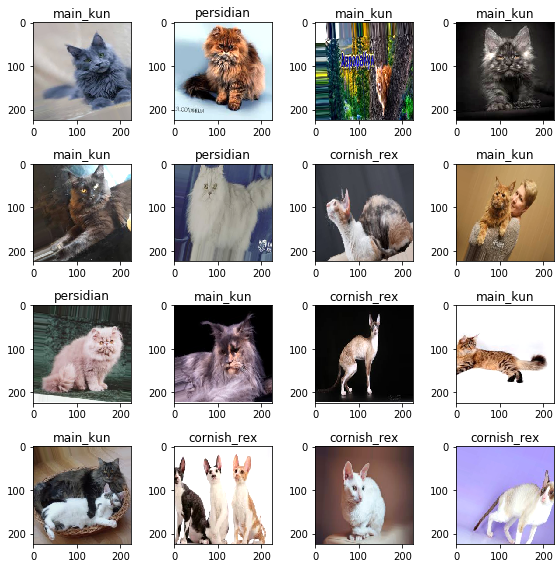

In [9]:
sample_images(train_generator, 16)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 167 samples in 0.000s...
[t-SNE] Computed neighbors for 167 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 167 / 167
[t-SNE] Mean sigma: 0.210848
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.543812
[t-SNE] KL divergence after 1000 iterations: 0.428217


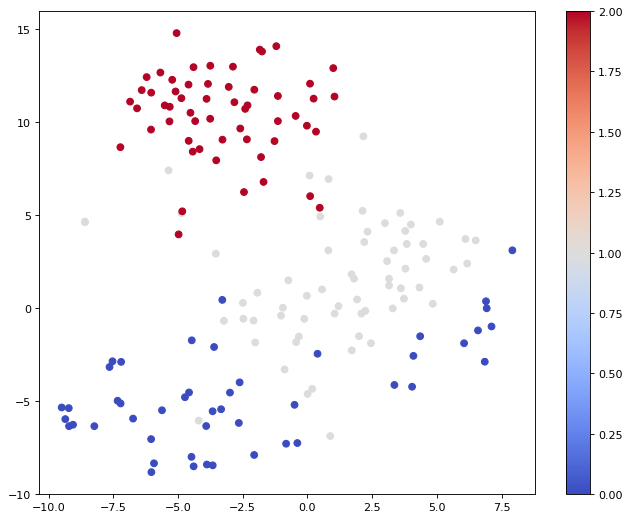

In [10]:
# до обучения сети

labels = []
images = []

for idx, (im, l) in enumerate(val_generator):
  if idx > val_steps:
    break
  else:
    images.extend([i for i in im])
    labels.extend(l)
images = np.array(images)

model_last_dense_layer = keras.Model(model.input, 
                                     model.layers[-2].output)
feature_vectors_trained = normalize_vectors(
    model_last_dense_layer.predict(images))
make_tsne_plot(feature_vectors_trained, labels)

In [11]:
model.compile('adam',
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(min_delta=0, patience=5, 
                                               restore_best_weights=True)
logdir = os.path.join("logs/classifier",
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [early_stopping, tensorboard]

history = model.fit(train_generator,
          epochs=10,
          validation_data=val_generator,
          callbacks=callbacks
         )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 43 steps, validate for 11 steps
Epoch 1/10
43/43 [==============================] - 19s 433ms/step - loss: 0.7859 - accuracy: 0.6172 - val_loss: 0.4827 - val_accuracy: 0.7784
Epoch 2/10
43/43 [==============================] - 11s 247ms/step - loss: 0.5809 - accuracy: 0.7552 - val_loss: 0.3166 - val_accuracy: 0.9102
Epoch 3/10
43/43 [==============================] - 10s 237ms/step - loss: 0.5953 - accuracy: 0.7715 - val_loss: 1.0487 - val_accuracy: 0.7246
Epoch 4/10
43/43 [==============================] - 10s 237ms/step - loss: 0.4909 - accuracy: 0.7982 - val_loss: 0.6295 - val_accuracy: 0.7665
Epoch 5/10
43/43 [==============================] - 10s 237ms/step - loss: 0.4576 - accuracy: 0.8042 - val_loss: 0.5004 - val_accuracy: 0.8743
Epoch 6/10
43/43 [==============================] - 10s 241ms/step - loss: 0.3613 - accuracy: 0.8694 - val_loss: 0.2881 - val_accuracy: 0.9102
Epoch 7/10
43/43 [==============================] 

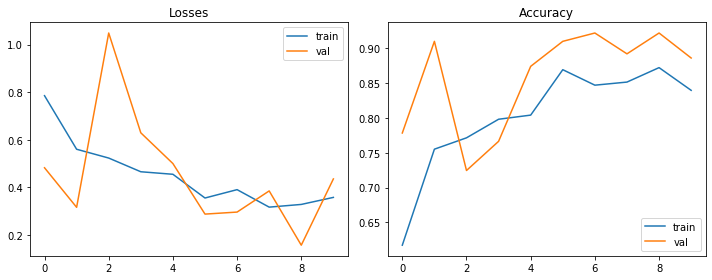

In [12]:
history_show(history)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 167 samples in 0.000s...
[t-SNE] Computed neighbors for 167 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 167 / 167
[t-SNE] Mean sigma: 0.096821
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.352222
[t-SNE] KL divergence after 1000 iterations: 0.110320


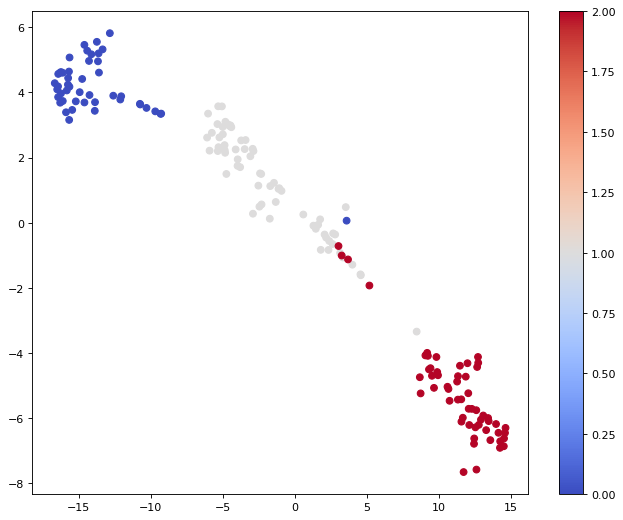

In [13]:
# после обучения

labels = []
images = []

for idx, (im, l) in enumerate(val_generator):
  if idx > val_steps:
    break
  else:
    images.extend([i for i in im])
    labels.extend(l)
images = np.array(images)

model_last_dense_layer = keras.Model(model.input, 
                                     model.layers[-2].output)
feature_vectors_trained = normalize_vectors(
    model_last_dense_layer.predict(images))
make_tsne_plot(feature_vectors_trained, labels)

In [14]:
# сделаем finetuning

pretrain_model = make_backbone_trainable(model)
pretrain_model.build([None] + list(IMG_SHAPE))
pretrain_model.summary()
pretrain_model.compile(keras.optimizers.Adam(learning_rate=1e-05),
                           loss='sparse_categorical_crossentropy', 
                           metrics=['accuracy'])
pretrain_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 1536)         54336736    input_6[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             multiple             0           model_4[1][0]                    
                                                                 dense_3[0][0]                    
                                                                 dense_4[0][0]                    
____________________________________________________________________________________________

In [15]:
early_stopping = keras.callbacks.EarlyStopping(min_delta=0.001, patience=2, 
                                               restore_best_weights=True)
logdir = os.path.join("logs/classifier",
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [early_stopping, tensorboard]

history = pretrain_model.fit(train_generator,
          epochs=10,
          validation_data=val_generator,
          callbacks=callbacks
         )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 43 steps, validate for 11 steps
Epoch 1/10
43/43 [==============================] - 30s 695ms/step - loss: 0.2889 - accuracy: 0.8872 - val_loss: 0.2163 - val_accuracy: 0.9281
Epoch 2/10
43/43 [==============================] - 14s 314ms/step - loss: 0.2398 - accuracy: 0.9006 - val_loss: 0.1183 - val_accuracy: 0.9401
Epoch 3/10
43/43 [==============================] - 13s 312ms/step - loss: 0.2023 - accuracy: 0.9332 - val_loss: 0.0961 - val_accuracy: 0.9641
Epoch 4/10
43/43 [==============================] - 13s 308ms/step - loss: 0.1569 - accuracy: 0.9540 - val_loss: 0.1006 - val_accuracy: 0.9461
Epoch 5/10
43/43 [==============================] - 13s 312ms/step - loss: 0.1613 - accuracy: 0.9525 - val_loss: 0.1106 - val_accuracy: 0.9461


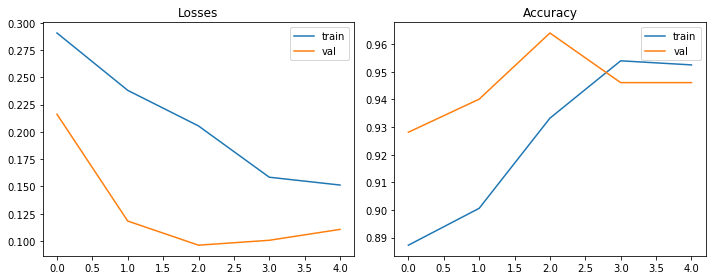

In [16]:
history_show(history)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 167 samples in 0.000s...
[t-SNE] Computed neighbors for 167 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 167 / 167
[t-SNE] Mean sigma: 0.091237
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.572407
[t-SNE] KL divergence after 1000 iterations: 0.094828


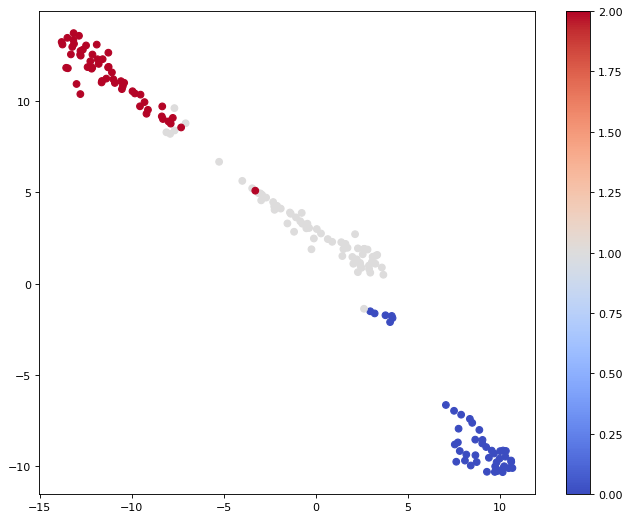

In [17]:
# после обучения pretrained модели

labels = []
images = []

for idx, (im, l) in enumerate(val_generator):
  if idx > val_steps:
    break
  else:
    images.extend([i for i in im])
    labels.extend(l)
images = np.array(images)

model_last_dense_layer = keras.Model(model.input, 
                                     model.layers[-2].output)
feature_vectors_trained = normalize_vectors(
    model_last_dense_layer.predict(images))
make_tsne_plot(feature_vectors_trained, labels)

In [83]:
# Проверим работу модели на предсказаниях
test_images, labels = next(iter(val_generator))
y_pred = np.argmax(model.predict(test_images), axis=1)

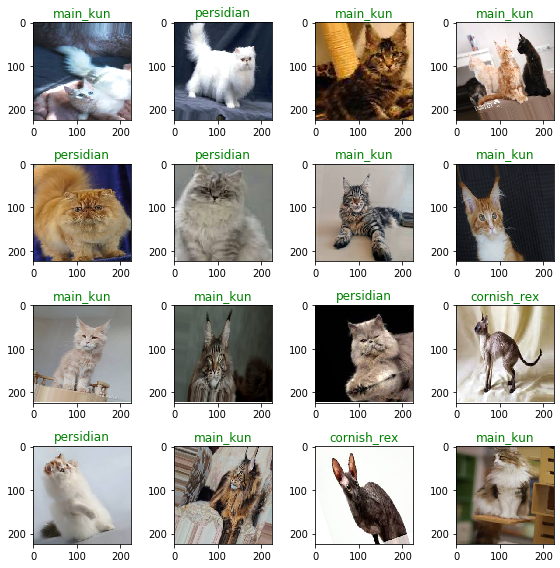

In [84]:
show_prediction(test_images, labels, model)

In [45]:
# обучим модель с фнкцией ошибки TripletLoss
# tl_base = make_backbone_trainable(model)
# tl_base = keras.Model(tl_base.input, tl_base.layers[-2].output)
# input_ = keras.layers.Input(IMG_SHAPE)
# x = tl_base(input_)
# x = keras.layers.Dense(64, activation='linear')(x)
# triplet_loss_model = keras.Model(input_, x)

triplet_loss_model = make_triple_loss_model(IMG_SHAPE)
triplet_loss_model.build([None] + list(IMG_SHAPE))
for layer in triplet_loss_model.layers:
    layer.trainable = True
triplet_loss_model.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_shape (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_29 (Model)                (None, 1536)         54336736    input_shape[0][0]                
__________________________________________________________________________________________________
dropout_25 (Dropout)            multiple             0           model_29[1][0]                   
                                                                 dense_37[0][0]                   
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 64)           98368       dropout_25[0][0]          

In [46]:
triplet_loss_model.compile(loss=tfa.losses.TripletSemiHardLoss(), 
                           optimizer=keras.optimizers.Adam(learning_rate=1e-04),
                           metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(min_delta=0.0, patience=5, 
                                               restore_best_weights=True)
logdir = os.path.join("logs/triplet_loss",
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard = keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks = [early_stopping]

history = triplet_loss_model.fit(train_generator,
                                 validation_data=val_generator,
                                 epochs=10,
                                 steps_per_epoch=training_steps,
                                 validation_steps=val_steps,
                                 callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 21 steps, validate for 5 steps
Epoch 1/10
21/21 [==============================] - 26s 1s/step - loss: 0.7682 - accuracy: 0.0296 - val_loss: 4.1550 - val_accuracy: 0.0000e+00
Epoch 2/10
21/21 [==============================] - 8s 391ms/step - loss: 0.6107 - accuracy: 0.0171 - val_loss: 2.6693 - val_accuracy: 0.0000e+00
Epoch 3/10
21/21 [==============================] - 8s 382ms/step - loss: 1.0251 - accuracy: 0.0016 - val_loss: 3.9634 - val_accuracy: 0.0000e+00
Epoch 4/10
21/21 [==============================] - 8s 382ms/step - loss: 0.8405 - accuracy: 0.0016 - val_loss: 5.8867 - val_accuracy: 0.0000e+00
Epoch 5/10
21/21 [==============================] - 8s 383ms/step - loss: 1.0691 - accuracy: 0.0016 - val_loss: 11.5268 - val_accuracy: 0.0000e+00
Epoch 6/10
21/21 [==============================] - 8s 383ms/step - loss: 0.2344 - accuracy: 0.0016 - val_loss: 10.2307 - val_accuracy: 0.0000e+00
Epoch 7/10
21/21 [===============

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 167 samples in 0.000s...
[t-SNE] Computed neighbors for 167 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 167 / 167
[t-SNE] Mean sigma: 0.094817
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.091869
[t-SNE] KL divergence after 1000 iterations: 0.131916


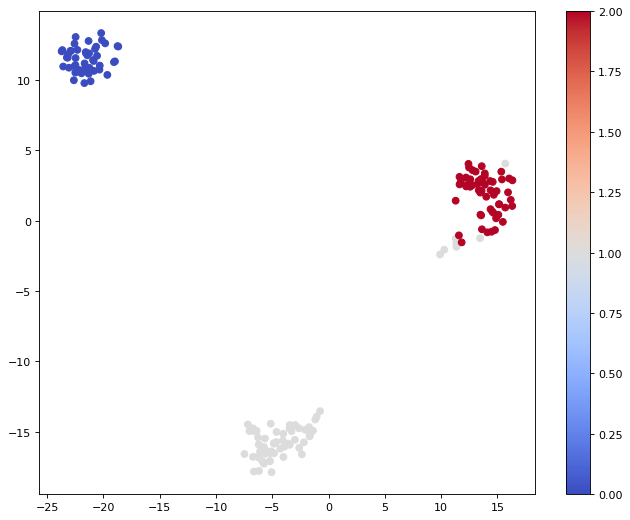

In [48]:
# после обучения triplet_loss модели

image_vectors = triplet_loss_model.predict(images)
feature_vectors = normalize_vectors(image_vectors)
make_tsne_plot(feature_vectors, labels)

In [50]:
test_images, labels = next(iter(val_generator))

In [53]:
triplet_loss_model.predict(test_images).shape

(32, 32)

In [ ]:
# thx https://gist.github.com/frogermcs/ed9fc359941efe54cc80d5b15f87bf77
import optparse

data_root = tf.keras.utils.get_file(
  'flower_photos',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

dataset_path = os.path.join(os.path.expanduser('~'), 
                            '.keras/datasets/flower_photos/')